In [ ]:
tickers = ["MSFT", "GOOGL", "TSLA", "META", "NFLX"]
with open("tickers.txt", "w") as f:
    for t in tickers:
        f.write(t + "\n")
print("tickers.txt created with", len(tickers), "tickers")

tickers.txt created with 5 tickers


In [ ]:
import os
import random
import math
from collections import deque, namedtuple
import numpy as np
import pandas as pd
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn
import torch.optim as optim
from tqdm import trange, tqdm
import matplotlib.pyplot as plt
import seaborn as sns

# ---------- Config (TUNED FOR ~30% RETURN) ----------
DATA_DIR = 'data'
TICKERS_FILE = 'tickers.txt'
START_DATE = '2015-01-01'
END_DATE = '2024-12-31'
WINDOW_SIZE = 20
MAX_SHARES = 12
FEATURES = ['open','high','low','close','volume']
EMB_SIZE = 16
BATCH_SIZE = 64
GAMMA = 0.99
LR = 8e-5
MEMORY_CAPACITY = 100000
TARGET_UPDATE = 800
TRAIN_STEPS = 120000
EPS_START = 1.0
EPS_END = 0.18
EPS_DECAY = 80000
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
TRANSACTION_COST = 0.0012

In [ ]:
# ---------- Replay Transition ----------
Transition = namedtuple('Transition', ('state', 'action', 'reward', 'next_state', 'done'))

def ensure_dir(d):
    if not os.path.exists(d):
        os.makedirs(d)

# ---------- MarketData ----------
class MarketData:
    def __init__(self, tickers_file=TICKERS_FILE, data_dir=DATA_DIR,
                 start=START_DATE, end=END_DATE):
        self.tickers_file = tickers_file
        self.data_dir = data_dir
        self.start = start
        self.end = end
        ensure_dir(self.data_dir)
        self.tickers = self._read_tickers()
        self.scalers = {}

    def _read_tickers(self):
        if not os.path.exists(self.tickers_file):
            raise FileNotFoundError(f"{self.tickers_file} not found.")
        with open(self.tickers_file, 'r') as f:
            tickers = [t.strip().upper() for t in f.readlines() if t.strip()]
        return tickers

    def get_train_val_test_split(self, ticker, train_end='2020-12-31', val_end='2022-12-31'):
        df = self.load_df(ticker)
        train_df = df[df.index <= train_end].copy()
        val_df   = df[(df.index > train_end) & (df.index <= val_end)].copy()
        test_df  = df[df.index > val_end].copy()
        return train_df, val_df, test_df

    def download_all(self):
        for t in tqdm(self.tickers, desc='Downloading'):
            path = os.path.join(self.data_dir, f'{t}.csv')
            if os.path.exists(path):
                continue
            df = yf.download(t, start=self.start, end=self.end, progress=False)
            if df.empty:
                print('Warning: empty data for', t)
                continue
            df.to_csv(path)

    def load_df(self, ticker):
        path = os.path.join(self.data_dir, f'{ticker}.csv')
        if not os.path.exists(path):
            raise FileNotFoundError(path)
        df = pd.read_csv(path, index_col=0, parse_dates=True)
        df = df.dropna()
        return df

    def compute_features(self, df):
        df = df.copy()
        for col in ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']:
            if col in df.columns:
                df[col] = pd.to_numeric(df[col], errors='coerce')
        df = df.dropna(subset=['Close', 'Volume'])
        df = df.fillna(method='bfill').fillna(method='ffill')
        df['ret'] = df['Close'].pct_change().fillna(0)
        df['log_ret'] = np.log(df['Close']).diff().fillna(0)
        df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
        df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
        df['ema10'] = df['Close'].ewm(span=10, adjust=False).mean()
        df['std5'] = df['Close'].rolling(5).std().fillna(0)
        delta = df['Close'].diff()
        up = delta.clip(lower=0)
        down = -1 * delta.clip(upper=0)
        roll_up = up.rolling(14).mean()
        roll_down = down.rolling(14).mean()
        rs = roll_up / (roll_down + 1e-6)
        df['rsi'] = 100.0 - (100.0 / (1.0 + rs))
        df['bb_upper'] = df['ma10'] + 2 * df['std5']
        df['bb_lower'] = df['ma10'] - 2 * df['std5']
        ema12 = df['Close'].ewm(span=12, adjust=False).mean()
        ema26 = df['Close'].ewm(span=26, adjust=False).mean()
        df['macd'] = ema12 - ema26
        df['macd_signal'] = df['macd'].ewm(span=9, adjust=False).mean()
        df['mom'] = df['Close'] - df['Close'].shift(10)
        df['vol'] = df['Volume']
        feature_cols = ['Close','Open','High','Low','ret','log_ret','ma5','ma10','ema10',
                        'std5','vol','rsi','bb_upper','bb_lower','macd','macd_signal','mom']
        df_features = df[feature_cols].apply(pd.to_numeric, errors='coerce').fillna(0)
        return df_features

    def fit_scaler(self):
        for t in tqdm(self.tickers, desc='Fitting scalers'):
            try:
                df = self.load_df(t)
            except FileNotFoundError:
                continue
            feat = self.compute_features(df)
            scaler = StandardScaler()
            scaler.fit(feat.values)
            self.scalers[t] = scaler

    def save_scalers(self, path='scalers.npy'):
        np.save(path, self.scalers)

    def load_scalers(self, path='scalers.npy'):
        self.scalers = np.load(path, allow_pickle=True).item()

In [ ]:
# ---------- TradingEnv ----------
class TradingEnv:
    def __init__(self, features_df, scaler, ticker_idx, window_size=WINDOW_SIZE, initial_cash=10000):
        self.df = features_df.reset_index(drop=True)
        self.scaler = scaler
        self.window = window_size
        self.ticker_idx = ticker_idx
        self.initial_cash = initial_cash
        self.TRANSACTION_COST = TRANSACTION_COST
        self.reset_episode()

    def reset_episode(self, start_idx=None):
        max_start = len(self.df) - self.window - 2
        if max_start <= 0:
            raise ValueError('Data too short for window size')
        self.pos = start_idx if start_idx is not None else random.randint(0, max_start)
        self.current_step = self.pos + self.window
        self.end_step = len(self.df) - 1
        self.cash = self.initial_cash
        self.shares = 0
        self.done = False
        return self._get_state()

    def _get_state(self):
        slice_df = self.df.iloc[self.current_step - self.window:self.current_step]
        X = self.scaler.transform(slice_df.values)
        X = X.flatten()
        state = np.concatenate([X, np.array([self.shares])])
        return {'obs': state.astype(np.float32), 'ticker_idx': self.ticker_idx}

    def step(self, action):
        price = float(self.df.iloc[self.current_step]['Close'])
        prev_val = self.cash + self.shares * price
        if action == 1 and self.shares < MAX_SHARES and self.cash >= price * (1 + self.TRANSACTION_COST):
            self.shares += 1
            self.cash -= price * (1 + self.TRANSACTION_COST)
        elif action == 2 and self.shares > 0:
            self.shares -= 1
            self.cash += price * (1 - self.TRANSACTION_COST)
        self.current_step += 1
        self.done = self.current_step >= self.end_step
        new_price = price if self.done else float(self.df.iloc[self.current_step]['Close'])
        new_val = self.cash + self.shares * new_price
        reward = (new_val - prev_val) / (prev_val + 1e-6)
        next_state = self._get_state()
        return next_state, reward, self.done, {}

# ---------- Replay Buffer ----------
class ReplayBuffer:
    def __init__(self, capacity=MEMORY_CAPACITY):
        self.capacity = capacity
        self.buffer = deque(maxlen=capacity)
    def push(self, *args):
        self.buffer.append(Transition(*args))
    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return Transition(*zip(*batch))
    def __len__(self):
        return len(self.buffer)

def stack_states(states):
    obs = np.stack([s['obs'] for s in states])
    ticker_idx = np.array([s['ticker_idx'] for s in states], dtype=np.int64)
    return obs, ticker_idx

# ---------- DQN Model ----------
class DQNModel(nn.Module):
    def __init__(self, state_dim, n_tickers, emb_size=EMB_SIZE, n_actions=3):
        super().__init__()
        self.emb = nn.Embedding(n_tickers, emb_size)
        hidden = 256
        self.net = nn.Sequential(
            nn.Linear(state_dim + emb_size, hidden),
            nn.ReLU(),
            nn.Linear(hidden, hidden),
            nn.ReLU(),
            nn.Linear(hidden, n_actions)
        )
    def forward(self, obs, ticker_idx):
        emb = self.emb(ticker_idx)
        x = torch.cat([obs, emb], dim=1)
        return self.net(x)

def select_action(state_dict, policy_net, steps_done, n_actions=3):
    eps = EPS_END + (EPS_START - EPS_END) * math.exp(-1. * steps_done / EPS_DECAY)
    sample = random.random()
    obs = torch.from_numpy(state_dict['obs']).float().unsqueeze(0).to(DEVICE)
    tidx = torch.tensor([state_dict['ticker_idx']], dtype=torch.long).to(DEVICE)
    if sample > eps:
        with torch.no_grad():
            return policy_net(obs, tidx).argmax(dim=1).item()
    else:
        return random.randrange(n_actions)

In [ ]:
def train_with_validation():
    md = MarketData()
    print('Tickers found:', len(md.tickers))
    md.download_all()
    md.fit_scaler()

    # ---------- Build data splits ----------
    train_store, val_store, test_store = [], [], []
    valid_tickers = []
    for i, t in enumerate(md.tickers):
        try:
            train_df, val_df, test_df = md.get_train_val_test_split(t)
        except FileNotFoundError:
            continue
        if len(train_df) < WINDOW_SIZE + 2: continue
        train_feat = md.compute_features(train_df)
        val_feat   = md.compute_features(val_df)
        test_feat  = md.compute_features(test_df)
        train_store.append((t, train_feat))
        val_store.append((t, val_feat))
        test_store.append((t, test_feat))
        valid_tickers.append(t)

    n_tickers = len(valid_tickers)
    print('Usable tickers:', n_tickers)

    scalers = {t: md.scalers[t] for t in valid_tickers}
    sample_x = train_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample_x.size + 1

    policy_net = DQNModel(state_dim, n_tickers).to(DEVICE)
    target_net = DQNModel(state_dim, n_tickers).to(DEVICE)
    target_net.load_state_dict(policy_net.state_dict())
    optimizer = optim.Adam(policy_net.parameters(), lr=LR)
    memory = ReplayBuffer()

    # ---------- Prefill ----------
    print('Prefilling replay buffer...')
    while len(memory) < 5000:
        tidx = random.randrange(n_tickers)
        t, feat = train_store[tidx]
        env = TradingEnv(feat, scalers[t], ticker_idx=tidx)
        s = env.reset_episode()
        done = False
        while not done and len(memory) < 5000:
            a = random.randrange(3)
            s2, r, done, _ = env.step(a)
            memory.push(s, a, r, s2, done)
            s = s2

    # ---------- Validation helper ----------
    def run_validation(net):
        net.eval()
        rets = []
        for tidx in range(n_tickers):
            t, feat = val_store[tidx]
            env = TradingEnv(feat, scalers[t], ticker_idx=tidx, initial_cash=10000)
            s = env.reset_episode()
            done = False
            while not done:
                obs = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
                tidx_t = torch.tensor([s['ticker_idx']], dtype=torch.long).to(DEVICE)
                with torch.no_grad():
                    a = net(obs, tidx_t).argmax(dim=1).item()
                s, _, done, _ = env.step(a)
            final_price = float(env.df.iloc[env.current_step-1]['Close'])
            final_val = env.cash + env.shares * final_price
            rets.append(final_val / env.initial_cash - 1.0)
        net.train()
        return np.mean(rets)

    # ---------- Training ----------
    steps_done = 0
    val_every = 10000
    val_returns = []

    pbar = trange(TRAIN_STEPS)
    for step in pbar:
        tidx = random.randrange(n_tickers)
        t, feat = train_store[tidx]
        env = TradingEnv(feat, scalers[t], ticker_idx=tidx)
        s = env.reset_episode()
        a = select_action(s, policy_net, steps_done)
        s2, r, done, _ = env.step(a)
        memory.push(s, a, r, s2, done)
        steps_done += 1

        if len(memory) >= BATCH_SIZE:
            trans = memory.sample(BATCH_SIZE)
            obs_batch, tidx_batch = stack_states(trans.state)
            obs_batch = torch.from_numpy(obs_batch).float().to(DEVICE)
            tidx_batch = torch.from_numpy(tidx_batch).long().to(DEVICE)
            action_batch = torch.tensor(trans.action, dtype=torch.long).unsqueeze(1).to(DEVICE)
            reward_batch = torch.tensor(trans.reward, dtype=torch.float32).unsqueeze(1).to(DEVICE)
            non_final_mask = torch.tensor([not d for d in trans.done], dtype=torch.bool).to(DEVICE)
            non_final_next = [s for s, d in zip(trans.next_state, trans.done) if not d]
            q_values = policy_net(obs_batch, tidx_batch).gather(1, action_batch)
            next_values = torch.zeros(BATCH_SIZE, 1, device=DEVICE)
            if non_final_next:
                next_obs, next_tidx = stack_states(non_final_next)
                next_obs = torch.from_numpy(next_obs).float().to(DEVICE)
                next_tidx = torch.from_numpy(next_tidx).long().to(DEVICE)
                next_q = target_net(next_obs, next_tidx)
                next_values[non_final_mask] = next_q.max(1)[0].detach().unsqueeze(1)
            expected_q = reward_batch + GAMMA * next_values
            loss = nn.MSELoss()(q_values, expected_q)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(policy_net.parameters(), 1.0)
            optimizer.step()

        if step % TARGET_UPDATE == 0:
            target_net.load_state_dict(policy_net.state_dict())

        if (step + 1) % val_every == 0:
            val_ret = run_validation(policy_net)
            val_returns.append((step + 1, val_ret))
            pbar.set_postfix({'step': step+1, 'val_ret': f'{val_ret*100:5.2f}%'})

    # ---------- Save ----------
    torch.save({
        'policy_state_dict': policy_net.state_dict(),
        'scalers': scalers,
        'tickers': valid_tickers,
        'val_history': val_returns
    }, 'dqn_trading_30percent.pth')
    print('Training complete. Model saved.')

# Run training
train_with_validation()

Tickers found: 5


Downloading:   0%|          | 0/5 [00:00<?, ?it/s]/tmp/ipython-input-3858282108.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  20%|██        | 1/5 [00:00<00:03,  1.14it/s]/tmp/ipython-input-3858282108.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  40%|████      | 2/5 [00:01<00:02,  1.38it/s]/tmp/ipython-input-3858282108.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  60%|██████    | 3/5 [00:01<00:01,  1.71it/s]/tmp/ipython-input-3858282108.py:39: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download(t, start=self.start, end=self.end, progress=False)
Downloading:  80%|████████  | 4/5 [0

Usable tickers: 5
Prefilling replay buffer...


100%|██████████| 120000/120000 [09:50<00:00, 203.11it/s, step=120000, val_ret=-12.09%]

Training complete. Model saved.


In [ ]:
def evaluate_and_plot(model_path='dqn_trading_30percent.pth', n_episodes=20):
    safe_types = [StandardScaler, np.float64, np.float32, np.int64, np.int32, np.bool_, np.int8, np.int16]
    with torch.serialization.safe_globals(safe_types):
        ckpt = torch.load(model_path, map_location=DEVICE, weights_only=False)

    scalers = ckpt['scalers']
    tickers = ckpt['tickers']

    md = MarketData()
    test_store = []
    for t in tickers:
        try:
            _, _, test_df = md.get_train_val_test_split(t)
        except FileNotFoundError:
            continue
        feat = md.compute_features(test_df)
        test_store.append((t, feat))

    n_tickers = len(tickers)
    sample_x = test_store[0][1].iloc[:WINDOW_SIZE].values
    state_dim = sample_x.size + 1

    policy_net = DQNModel(state_dim, n_tickers).to(DEVICE)
    policy_net.load_state_dict(ckpt['policy_state_dict'])
    policy_net.eval()

    results = {}
    sharpe_dict = {}

    for i, (t, feat) in enumerate(test_store):
        returns = []
        daily_rets = []

        for _ in range(n_episodes):
            env = TradingEnv(feat, scalers[t], ticker_idx=i, initial_cash=10000)
            s = env.reset_episode()
            done = False
            ep_ret = 0.0

            while not done:
                obs = torch.from_numpy(s['obs']).float().unsqueeze(0).to(DEVICE)
                tidx_t = torch.tensor([s['ticker_idx']], dtype=torch.long).to(DEVICE)
                a = policy_net(obs, tidx_t).argmax(dim=1).item()
                s, r, done, _ = env.step(a)
                ep_ret += r

            final_price = float(env.df.iloc[env.current_step-1]['Close'])
            final_val = env.cash + env.shares * final_price
            total_ret = final_val / env.initial_cash - 1.0

            returns.append(total_ret)
            daily_rets.append(ep_ret)

        results[t] = np.mean(returns)

        dr = pd.Series(daily_rets)
        sharpe = (dr.mean() / dr.std()) * np.sqrt(252) if dr.std() != 0 else 0
        sharpe_dict[t] = sharpe

    # ================================
    # PLOT 1 — Evaluation Returns
    # ================================
    plt.figure(figsize=(8, 5))
    plt.bar(results.keys(), [v * 100 for v in results.values()])
    plt.title("Evaluation Return per Ticker")
    plt.ylabel("Return (%)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # ================================
    # PLOT 2 — Sharpe Ratio
    # ================================
    plt.figure(figsize=(8, 5))
    plt.bar(sharpe_dict.keys(), sharpe_dict.values())
    plt.title("Sharpe Ratio per Ticker")
    plt.ylabel("Sharpe")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    # Numeric Summary
    print("\n=== Summary ===")
    for t in tickers:
        print(f"{t:5}: Eval {results[t]*100:6.2f}% | Sharpe {sharpe_dict[t]:5.2f}")
    print(f"Avg Eval Return: {np.mean(list(results.values()))*100:5.2f}%")

    return results, sharpe_dict


/tmp/ipython-input-3858282108.py:49: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df = pd.read_csv(path, index_col=0, parse_dates=True)
/tmp/ipython-input-3858282108.py:59: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='bfill').fillna(method='ffill')
/tmp/ipython-input-3858282108.py:62: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma5'] = df['Close'].rolling(5).mean().fillna(method='bfill')
/tmp/ipython-input-3858282108.py:63: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['ma10'] = df['Close'].rolling(10).mean().fillna(method='bfill')
/tmp/ipython-input

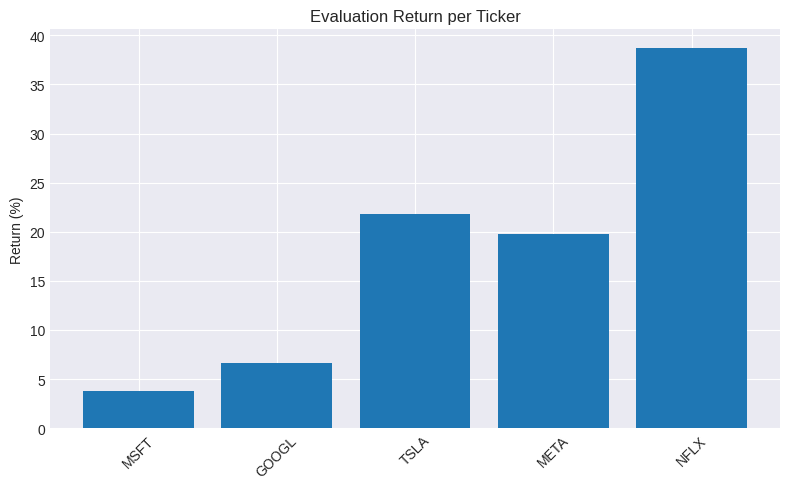

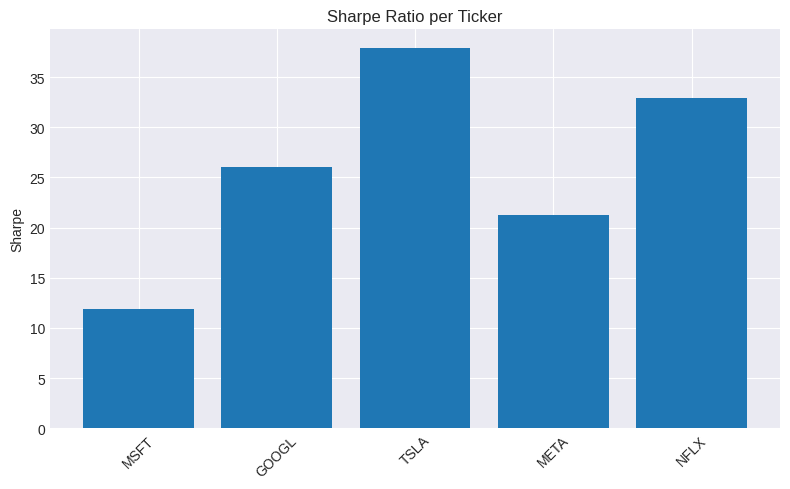


=== Summary ===
MSFT : Eval   3.79% | Sharpe 11.88
GOOGL: Eval   6.67% | Sharpe 26.00
TSLA : Eval  21.79% | Sharpe 37.87
META : Eval  19.79% | Sharpe 21.29
NFLX : Eval  38.68% | Sharpe 32.94
Avg Eval Return: 18.14%


({'MSFT': np.float64(0.037867906044738844),
  'GOOGL': np.float64(0.06667623980236802),
  'TSLA': np.float64(0.21785309152859494),
  'META': np.float64(0.19793012822421258),
  'NFLX': np.float64(0.3867967579413451)},
 {'MSFT': np.float64(11.880650713532129),
  'GOOGL': np.float64(26.00025676575523),
  'TSLA': np.float64(37.86619053845453),
  'META': np.float64(21.293315999182308),
  'NFLX': np.float64(32.93902699112705)})

In [ ]:
evaluate_and_plot()